<a href="https://colab.research.google.com/github/Bone-Age-Maisha/paper_1/blob/main/surgery.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt


In [2]:
IMG_SIZE = [224, 224]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#vgg = VGG16(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)

In [5]:
#for layer in vgg.layers:
  #layer.trainable = False

In [6]:
#x = Flatten()(vgg.output)

In [7]:
#vgg.summary()

**DATA_PREP**

In [8]:
import pandas as pd
train_dir = '/content/drive/MyDrive/RSNA/archive'
train_df = pd.read_csv('/content/drive/MyDrive/RSNA/archive/boneage-training-dataset.csv')

In [9]:
import os
age_df = train_df 
age_df['path'] = age_df['id'].map(lambda x: os.path.join(train_dir,
                                                         'boneage-training-dataset', 
                                                         'boneage-training-dataset', 
                                                         '{}.png'.format(x)))
age_df['exists'] = age_df['path'].map(os.path.exists)
print(age_df['exists'].sum(), 'images found of', age_df.shape[0], 'total')
age_df['gender'] = age_df['male'].map(lambda x: 'male' if x else 'female')
boneage_mean = age_df['boneage'].mean()
boneage_div = 2*age_df['boneage'].std()
age_df['boneage_zscore'] = age_df['boneage'].map(lambda x: (x-boneage_mean)/boneage_div)
age_df.dropna(inplace = True)
age_df.sample(3)

12611 images found of 12611 total


,id,boneage,male,path,exists,gender,boneage_zscore
6448,8732,204,False,/content/drive/MyDrive/RSNA/archive/boneage-tr...,True,female,0.930980
7418,9805,216,True,/content/drive/MyDrive/RSNA/archive/boneage-tr...,True,male,1.076674
8492,10999,165,True,/content/drive/MyDrive/RSNA/archive/boneage-tr...,True,male,0.457472


New Data Size: 8000 Old Size: 12611


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb5adb6ef10>]],
      dtype=object)

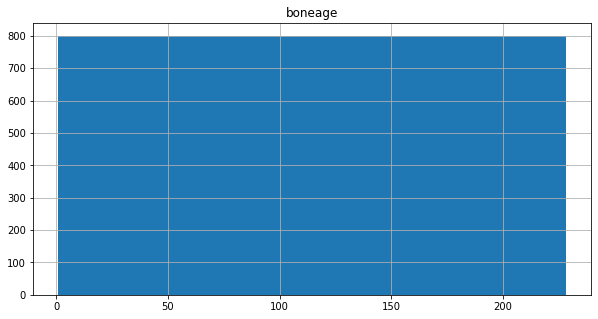

In [10]:
age_df['boneage_category'] = pd.cut(age_df['boneage'], 10)
new_age_df = age_df.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(400, replace = True)
                                                      ).reset_index(drop = True)
print('New Data Size:', new_age_df.shape[0], 'Old Size:', age_df.shape[0])
new_age_df[['boneage', 'male']].hist(figsize = (10, 5))

In [11]:
from sklearn.model_selection import train_test_split

train_df,test_df = train_test_split(
                                                     new_age_df, 
                                   test_size = 0.2, 
                                   random_state = 2018,
                                   stratify = new_age_df['boneage_category'])

train_df, valid_df= train_test_split(
                                                   new_age_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = new_age_df['boneage_category'])
print('train', train_df.shape[0], 'validation', valid_df.shape[0] , 'test', test_df.shape[0])

train 6000 validation 2000 test 1600


In [12]:
from keras.preprocessing.image import ImageDataGenerator
#IMG_SIZE = (256, 256)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range = 0.1, 
                              width_shift_range = 0.1, 
                              rotation_range = 10, 
                              shear_range = 0.05,
                              fill_mode = 'nearest',
                              zoom_range=0.15)

In [13]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.filepaths.extend(df_gen.filenames)
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' 
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [14]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 64)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 6000 images


In [15]:
t_x, t_y = next(train_gen)

In [16]:
valid_gen = flow_from_dataframe(core_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 64) 

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images


In [17]:
test_gen = flow_from_dataframe(core_idg, 
                              test_df, 
                             path_col = 'path',
                            y_col = 'boneage_zscore', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = 500)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 1600 images


In [18]:
test_X, test_Y = next(test_gen)

In [19]:
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

**Attention**

In [20]:
vgg1 = VGG16(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg1.layers:
  layer.trainable = False



58900480/58889256 [==============================] - 0s 0us/step


In [21]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
import keras.backend as K

in_lay = Input(t_x.shape[1:])
pt_features = vgg1(in_lay)
#pt_depth = vgg1.get_output_shape_at(0)[-1]
pt_depth = 512
from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)
#xx=attn_layer.get_output_at(0)
#yy=attn_layer.get_output_at(0)


mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'linear')(dr_steps) # linear is what 16bit did
bone_age_model = Model(inputs = [in_lay], outputs = [out_layer])

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = [mae_months])

bone_age_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 7, 7, 512)   2048        ['vgg16[0][0]']                  
 alization)                                                                                       
                                                                                              

In [23]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint



checkpoint = ModelCheckpoint(filepath='mymodel.h5', 
                               verbose=2, save_best_only=True)

callbacks = [checkpoint]

start = datetime.now()

model_history=bone_age_model .fit_generator(
  train_gen,
  validation_data=(test_X,test_Y),
  epochs=4,
  steps_per_epoch=5,
  validation_steps=32,
    callbacks=callbacks ,verbose=2)


duration = datetime.now() - start
print("Training completed in time: ", duration)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/4

Epoch 1: val_loss improved from inf to 1.01312, saving model to mymodel.h5
5/5 - 431s - loss: 0.4224 - mae_months: 43.3715 - val_loss: 1.0131 - val_mae_months: 73.2553 - 431s/epoch - 86s/step
Epoch 2/4

Epoch 2: val_loss improved from 1.01312 to 0.59737, saving model to mymodel.h5
5/5 - 430s - loss: 0.3637 - mae_months: 39.9833 - val_loss: 0.5974 - val_mae_months: 53.3181 - 430s/epoch - 86s/step
Epoch 3/4

Epoch 3: val_loss did not improve from 0.59737
5/5 - 419s - loss: 0.4014 - mae_months: 41.7395 - val_loss: 0.6305 - val_mae_months: 54.0005 - 419s/epoch - 84s/step
Epoch 4/4

Epoch 4: val_loss did not improve from 0.59737
5/5 - 436s - loss: 0.3351 - mae_months: 37.5010 - val_loss: 0.7624 - val_mae_months: 60.5148 - 436s/epoch - 87s/step
Training completed in time:  0:29:20.045499


**GRADCAM**

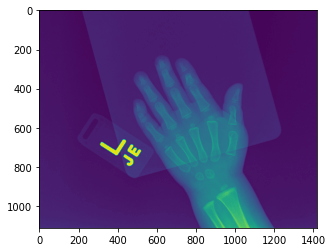

In [24]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt



last_conv_layer_name = "multiply_2"

path="a"
for column in train_df['path']:
  path=column
  img = mpimg.imread(column)
  plt.imshow(img)
  break

In [ ]:
print(path)

In [25]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

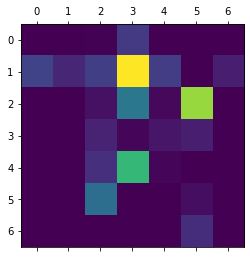

In [26]:
import keras
import tensorflow as tf
preprocess_input = keras.applications.vgg16.preprocess_input
#img_path="/content/drive/MyDrive/RSNA/archive/boneage-training-dataset/boneage-training-dataset/1501.png"
img_array = preprocess_input(get_img_array(path, size=IMG_SIZE))

last_conv_layer_name = "multiply"
# Print what the top predicted class is
preds = bone_age_model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, bone_age_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

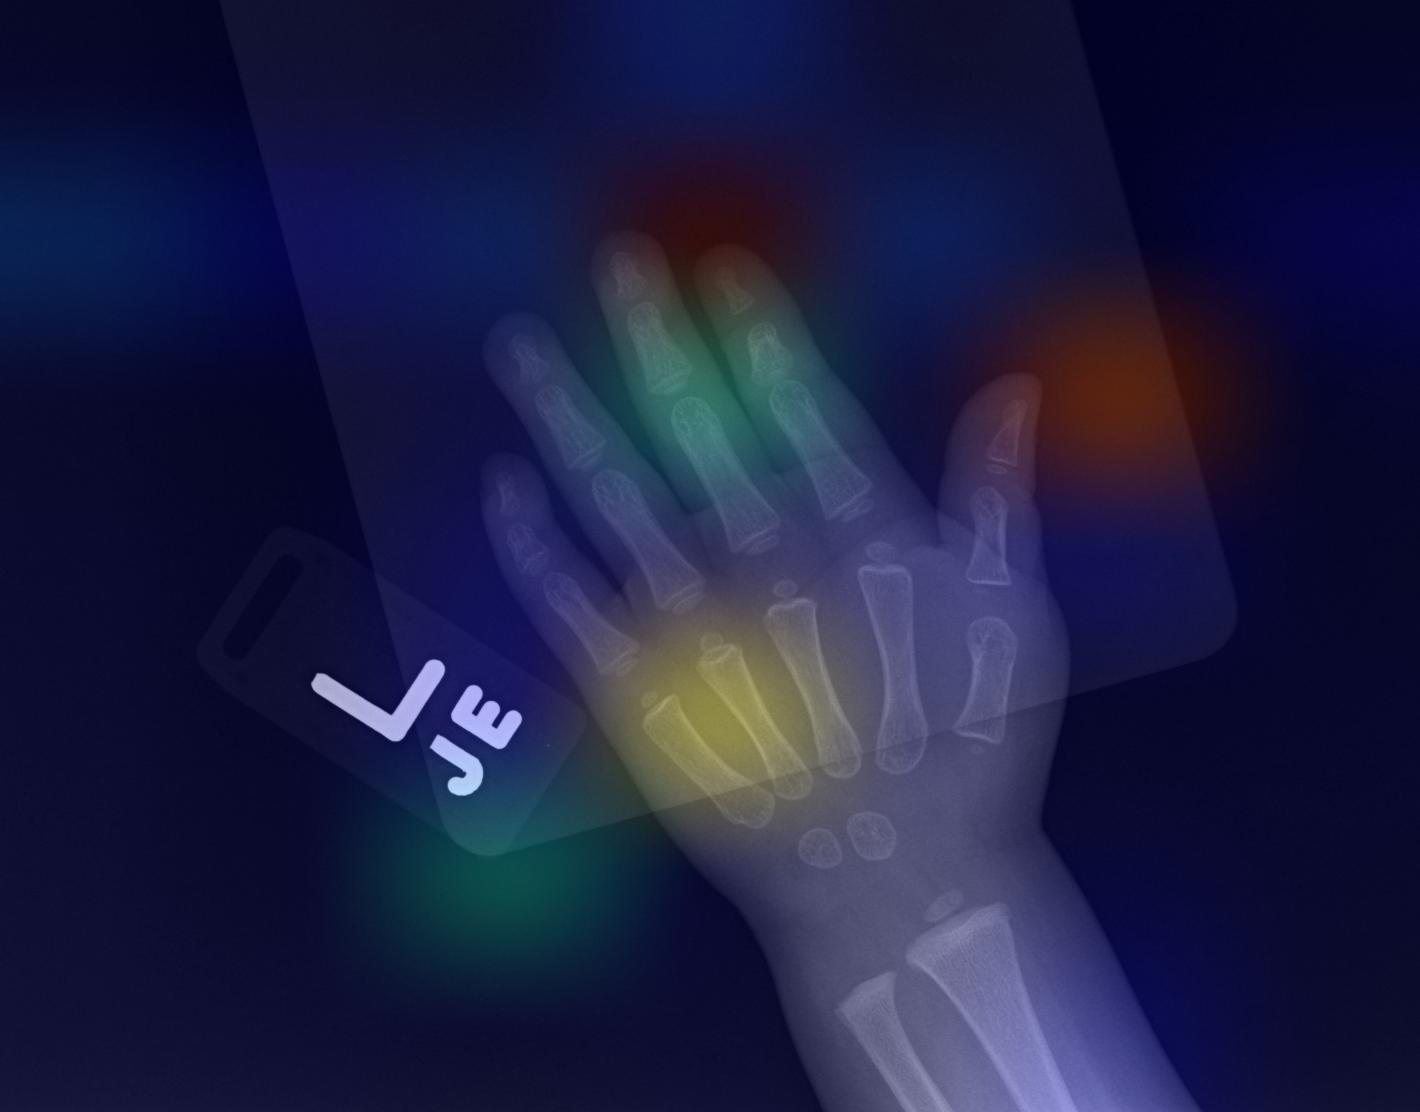

In [27]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
save_and_display_gradcam(path, heatmap)

**Another_Approach**

---



---



**Show_Attention**

In [28]:
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, LocallyConnected2D, Lambda
from keras.models import Model
in_lay = Input(t_x.shape[1:])
base_pretrained_model = VGG16(input_shape =  t_x.shape[1:], include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False
pt_features = base_pretrained_model(in_lay)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]

from keras.layers import BatchNormalization
bn_features = BatchNormalization()(pt_features)

# here we do an attention mechanism to turn pixels in the GAP on an off

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(bn_features)
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = LocallyConnected2D(1, 
                                kernel_size = (1,1), 
                                padding = 'valid', 
                                activation = 'sigmoid')(attn_layer)
up_c2_w = np.ones((1, 1, 1, pt_depth))
up_c2 = Conv2D(pt_depth, kernel_size = (1,1), padding = 'same', 
               activation = 'linear', use_bias = False, weights = [up_c2_w])
up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)
# to account for missing values from the attention model
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])
gap_dr = Dropout(0.5)(gap)
dr_steps = Dropout(0.25)(Dense(1024, activation = 'elu')(gap_dr))
out_layer = Dense(1, activation = 'linear')(dr_steps) # linear is what 16bit did
bone_age_model = Model(inputs = [in_lay], outputs = [out_layer])
from keras.metrics import mean_absolute_error
def mae_months(in_gt, in_pred):
    return mean_absolute_error(boneage_div*in_gt, boneage_div*in_pred)

bone_age_model.compile(optimizer = 'adam', loss = 'mse',
                           metrics = [mae_months])

bone_age_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, 7, 7, 512)    14714688    ['input_3[0][0]']                
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 7, 7, 512)   2048        ['vgg16[0][0]']                  
 rmalization)                                                                                     
                                                                                            

In [29]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('bone_age')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)


reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=5) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [31]:
bone_age_model.fit_generator(train_gen, 
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


94/94 [==============================] - ETA: 0s - loss: 0.2970 - mae_months: 35.2880 
Epoch 1: val_loss improved from inf to 0.33204, saving model to bone_age_weights.best.hdf5
94/94 [==============================] - 3544s 38s/step - loss: 0.2970 - mae_months: 35.2880 - val_loss: 0.3320 - val_mae_months: 39.3201 - lr: 0.0010


In [32]:
bone_age_model.load_weights(weight_path)

In [33]:
import keras
import tensorflow as tf
preprocess_input = keras.applications.vgg16.preprocess_input
#img_path="/content/drive/MyDrive/RSNA/archive/boneage-training-dataset/boneage-training-dataset/1501.png"
img_array = preprocess_input(get_img_array(path, size=IMG_SIZE))


# Print what the top predicted class is
preds = bone_age_model.predict(img_array)
print(preds)

[[0.5220961]]


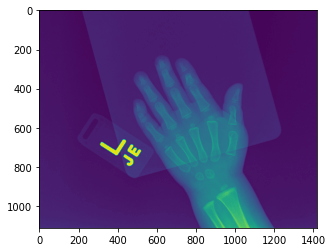

In [34]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt



last_conv_layer_name = "multiply_1"

path="a"
for column in train_df['path']:
  path=column
  img = mpimg.imread(column)
  plt.imshow(img)
  break

In [35]:
def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]


    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [36]:
# get the attention layer since it is the only one with a single output dim
for attn_layer in bone_age_model.layers:
    c_shape = attn_layer.get_output_shape_at(0)
    if len(c_shape)==4:
        if c_shape[-1]==1:
            print(attn_layer)
            break

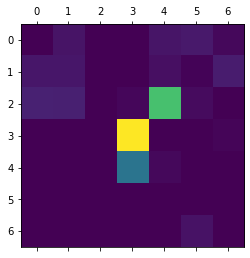

In [37]:
import keras
import tensorflow as tf
preprocess_input = keras.applications.vgg16.preprocess_input
#img_path="/content/drive/MyDrive/RSNA/archive/boneage-training-dataset/boneage-training-dataset/1501.png"
img_array = preprocess_input(get_img_array(path, size=IMG_SIZE))


# Print what the top predicted class is
preds = bone_age_model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])
last_conv_layer_name="multiply_1"
# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, bone_age_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

In [ ]:
bone_age_model.get_input_at(0)

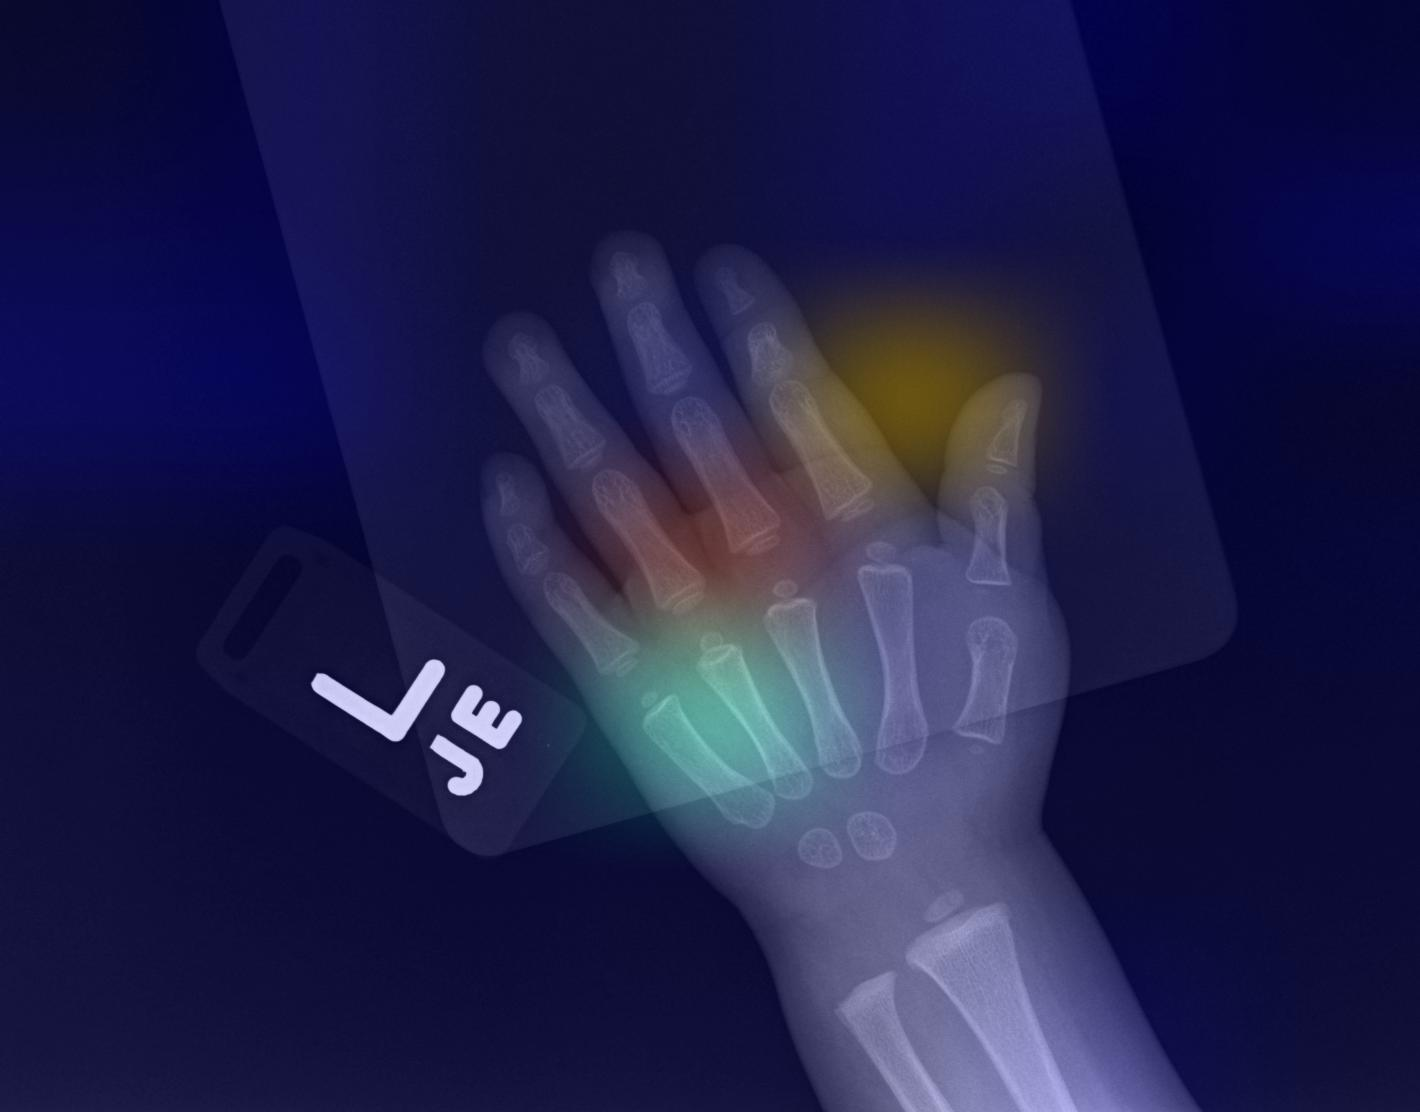

In [39]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))
save_and_display_gradcam(path, heatmap)

**doesnot** **work**

In [ ]:
import keras.backend as K
rand_idx = np.random.choice(range(len(test_X)), size = 6)
attn_func = K.function(inputs = [bone_age_model.get_input_at(0), K.learning_phase()],
           outputs =" conv2d_23"
          )
fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))
[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func([cur_img, 0])[0]
    img_ax.imshow(cur_img[0,:,:,0], cmap = 'bone')
    attn_ax.imshow(attn_img[0, :, :, 0], cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_age = boneage_div*test_Y[c_idx]+boneage_mean
    img_ax.set_title('Hand Image\nAge:%2.2fY' % (real_age/12))
    pred_age = boneage_div*bone_age_model.predict(cur_img)+boneage_mean
    attn_ax.set_title('Attention Map\nPred:%2.2fY' % (pred_age/12))
fig.savefig('attention_map.png', dpi = 300)